# assignment_1_09_file_1

<h1><center>DSA 4212: Year 2022</center></h1>
<h3><center> Assignment 1 (Deadline: Sunday 27th March at 23:59) </center></h3>
<h4><center> Group Number: 9 </center></h4>
<h4><center> Group Member 1: Lee Wei Qing, A0205666B </center></h4>
<h4><center> Group Member 2: Madeline Lim Chia Bing, A0205053W </center></h4>
<h4><center> Group Member 3: Mabel Lee Wei Ling, A0204397B </center></h4>
<h4><center> Group Member 4: Wu Wei Ye, A0200578H </center></h4>




## **Contents**
### 1. Logistic Regression Model with Different optimisation methods
> #### 1.1 Naive Gradient Descent 
> #### 1.2 Stochastic Gradient Descent
> #### 1.3 Stochastic Gradient Descent with momentum

### 2. Model Training and Testing
> #### 2.1 Different sizes of training set
> #### 2.2 Different resolution

### 3. Image Preprocessing, Further training and testing
> #### 3.1 Exploratory analysis
> #### 3.2 Training Model with Stochastic Gradient Descent with momentum (best model) on processed images






In [ ]:
%matplotlib inline
from jax.config import config
config.update("jax_enable_x64", True) # for higher accuracy

import jax
import jax.numpy as np

import pylab as plt
import imageio
import os
import numpy as onp
# to install scikit-image: !pip install scikit-image
from skimage.transform import rescale, resize, downscale_local_mean
import pandas as pd
import time

In [ ]:
# file paths
path = "./img_celeba_small/"
path_csv = "celeba.csv"

In [ ]:
total_img_num = 20000

all_img = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f)) and f.endswith(".jpg")]
all_img.sort()
attribute = pd.read_csv(path_csv)
attribute = attribute[:total_img_num]

In [ ]:
# reading in N_to_load numbers of images and converting to array
df = []
default_res = (100, 100)

start = time.time()
for k, file in enumerate(all_img[:total_img_num]):
    im = imageio.imread(os.path.join(path, file)).astype(float)
    im = resize(im, default_res)

    df.append(im)

    n_files_loaded_so_far = k+1
    if n_files_loaded_so_far % 1000 == 0:
        speed = n_files_loaded_so_far / (time.time() - start)
        print(f"Files loaded: {n_files_loaded_so_far} \t Loading Speed: {speed:2.1f} files loaded per second")

Files loaded: 1000 	 Loading Speed: 290.8 files loaded per second
Files loaded: 2000 	 Loading Speed: 290.8 files loaded per second
Files loaded: 3000 	 Loading Speed: 287.8 files loaded per second
Files loaded: 4000 	 Loading Speed: 282.5 files loaded per second
Files loaded: 5000 	 Loading Speed: 278.1 files loaded per second
Files loaded: 6000 	 Loading Speed: 278.2 files loaded per second
Files loaded: 7000 	 Loading Speed: 278.8 files loaded per second
Files loaded: 8000 	 Loading Speed: 279.6 files loaded per second
Files loaded: 9000 	 Loading Speed: 278.9 files loaded per second
Files loaded: 10000 	 Loading Speed: 276.4 files loaded per second
Files loaded: 11000 	 Loading Speed: 275.1 files loaded per second
Files loaded: 12000 	 Loading Speed: 275.9 files loaded per second
Files loaded: 13000 	 Loading Speed: 277.4 files loaded per second
Files loaded: 14000 	 Loading Speed: 278.5 files loaded per second
Files loaded: 15000 	 Loading Speed: 279.8 files loaded per second
File

In [ ]:
# splitting data into training and testing set
def train_test_split(arr, train_num, test_num, res_x, res_y, is_colored):
    dim = res_x * res_y
    if is_colored:
        dim *= 3
    X_train = onp.array(df[:train_num]).reshape(train_num, dim)
    X_test = onp.array(df[-test_num:]).reshape(test_num, dim)
    y_train = onp.array(attribute.loc[:train_num-1, 'Male'])
    y_test = onp.array(attribute.loc[len(arr)-test_num:, 'Male'])
    return X_train, X_test, y_train, y_test

In [ ]:
res_x = 100
res_y = 100
X_train, X_test, y_train, y_test = train_test_split(df, 15000, 5000, res_x, res_y, True)

# 1. Logistic Regression Model with Different optimisation methods
> #### 1.1 Naive Gradient Descent 
> #### 1.2 Stochastic Gradient Descent
> #### 1.3 Stochastic Gradient Descent with momentum





In [ ]:
onp.random.seed(30)
beta_init = onp.random.normal(0,scale=1/np.sqrt(X_train.shape[1]),size=(X_train.shape[1]))

In [ ]:
def prediction(beta, x):
    proba = 1. / (1. + np.exp(-np.dot(x,beta)))
    return proba

@jax.jit
def compute_error_rate(beta, X, Y):
    prediction_batch = jax.vmap(prediction, in_axes=(None, 0))
    pred_bool = prediction_batch(beta, X) > 0.5
    pred = 2*pred_bool - 1
    return np.mean(Y == pred)

@jax.jit
def loss_single(beta, x, y):
    return np.log(1. + np.exp(-y * np.dot(x,beta)))

@jax.jit
def loss(beta, X, Y):
    loss_all = jax.vmap(loss_single, in_axes=(None, 0, 0))
    loss_individuals = loss_all(beta, X_train, y_train)
    return np.mean(loss_individuals)

loss_value_and_grad = jax.jit(jax.value_and_grad(loss))

## 1.1 Naive Gradient Descent (Automatic Learning Rate)

In [ ]:
def GD(beta, X_train, y_train, n_iter, learning_rate_init, alpha):
    start_time = time.time()
    loss_history = []
    history_learning_rate = []
    first_iter = True

    for k in range(n_iter):
        v,g = loss_value_and_grad(beta, X_train, y_train)
        if first_iter:
            learning_rate = learning_rate_init
            first_iter = False
        else:
            learning_rate = history_learning_rate[-1]

        while loss(beta - learning_rate * g, X_train, y_train) > v + alpha * learning_rate * np.dot(g, -g):
            learning_rate = alpha * learning_rate

        beta = beta - learning_rate * g
        history_learning_rate.append(learning_rate)
        loss_history.append(v)
        
        if k % 300 == 0:
            err_train = 100*compute_error_rate(beta, X_train, y_train)
            err_val= 100*compute_error_rate(beta, X_test, y_test)        
            print(f"iter:{k} \t Loss:{v:2.3f} \t error(train):{err_train:2.1f}% \t error(val):{err_val:2.1f}%")
    print("Took", time.time() - start_time, "s to run.")
    return loss_history, beta

In [ ]:
n_iter = 4500
learning_rate_init = 1.
alpha = 0.5
beta = onp.copy(beta_init)

In [ ]:
loss_history_1, beta_1 = GD(beta, X_train, y_train, n_iter, learning_rate_init, alpha)

iter:0 	 Loss:30.269 	 error(train):48.6% 	 error(val):48.2%
iter:300 	 Loss:7.766 	 error(train):66.0% 	 error(val):65.3%
iter:600 	 Loss:6.167 	 error(train):70.0% 	 error(val):68.9%
iter:900 	 Loss:5.284 	 error(train):72.5% 	 error(val):71.2%
iter:1200 	 Loss:4.700 	 error(train):74.3% 	 error(val):73.4%
iter:1500 	 Loss:4.283 	 error(train):75.8% 	 error(val):74.7%
iter:1800 	 Loss:3.960 	 error(train):76.9% 	 error(val):75.7%
iter:2100 	 Loss:3.699 	 error(train):77.8% 	 error(val):76.6%
iter:2400 	 Loss:3.481 	 error(train):78.6% 	 error(val):77.7%
iter:2700 	 Loss:3.295 	 error(train):79.3% 	 error(val):78.4%
iter:3000 	 Loss:3.135 	 error(train):79.9% 	 error(val):78.8%
iter:3300 	 Loss:2.998 	 error(train):80.4% 	 error(val):79.5%
iter:3600 	 Loss:2.878 	 error(train):80.9% 	 error(val):80.0%
iter:3900 	 Loss:2.772 	 error(train):81.5% 	 error(val):80.5%
iter:4200 	 Loss:2.678 	 error(train):81.8% 	 error(val):80.9%
Took 2689.7291781902313 s to run.


In [ ]:
compute_error_rate(beta_1, X_train, y_train)

DeviceArray(0.8218, dtype=float64)

In [ ]:
compute_error_rate(beta_1, X_test, y_test)

DeviceArray(0.8124, dtype=float64)

Text(0.5, 0, 'iter')

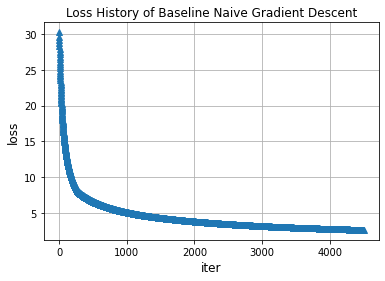

In [ ]:
plt.plot(loss_history_1, "-^")
#plt.yscale("log")
plt.grid(True)
plt.title("Loss History of Baseline Naive Gradient Descent")
plt.ylabel("loss", fontsize = 12)
plt.xlabel("iter", fontsize = 12)

In [ ]:
from sklearn.metrics import roc_auc_score
def AUC(beta, X_test, y_test):
    prediction_batch = jax.vmap(prediction, in_axes=(None, 0))
    pred_bool = prediction_batch(beta, X_test) > 0.5
    pred = 2*pred_bool - 1
    return(roc_auc_score(y_test, pred))

In [ ]:
AUC(beta_1, X_test, y_test)

0.8067215408791862

## 1.2 Stochastic Gradient Descent

In [ ]:
def SGD(b, X, Y, n, m, lr):
    start_time = time.time()
    N = len(X_train)
    img_indices = onp.arange(N)

    loss_history = []
    loss_history_end_epoch = []
    for epoch in range(n):
        n_minibatch = N // m + 1
        onp.random.shuffle(img_indices)

        all_loss_within_epoch = []
        for k in range(n_minibatch):
            batch_indices = onp.arange(k*m, (k+1)*m) % N
            batch_indices = img_indices[batch_indices]
            X_minibatch = X[batch_indices]
            y_minibatch = Y[batch_indices]

            val, grad = loss_value_and_grad(b, X_minibatch, y_minibatch)
            b = b - lr * grad

            loss_history.append(val)
            all_loss_within_epoch.append(val)
        loss_history_end_epoch.append(onp.mean(all_loss_within_epoch))
        err_train = 100*compute_error_rate(b, X, Y)
        err_val= 100*compute_error_rate(b, X_test, y_test)        
        print(f"epoch:{epoch} \t Loss:{val:2.3f} \t error(train):{err_train:2.1f}% \t error(val):{err_val:2.1f}%")
    print("Took", time.time() - start_time, "s to run.")
    return loss_history_end_epoch, b

In [ ]:
n_epoch = 25
minibatch_size = 50
beta = onp.copy(beta_init)
learning_rate = 0.000001

In [ ]:
loss_history_2, beta_2 = SGD(beta, X_train, y_train, n_epoch, minibatch_size, learning_rate)

epoch:0 	 Loss:16.714 	 error(train):66.3% 	 error(val):66.5%
epoch:1 	 Loss:13.701 	 error(train):70.0% 	 error(val):69.9%
epoch:2 	 Loss:9.172 	 error(train):74.8% 	 error(val):74.2%
epoch:3 	 Loss:8.650 	 error(train):76.0% 	 error(val):75.1%
epoch:4 	 Loss:4.760 	 error(train):83.4% 	 error(val):82.8%
epoch:5 	 Loss:2.994 	 error(train):86.7% 	 error(val):86.4%
epoch:6 	 Loss:2.766 	 error(train):87.6% 	 error(val):87.2%
epoch:7 	 Loss:3.448 	 error(train):86.1% 	 error(val):85.9%
epoch:8 	 Loss:3.696 	 error(train):82.7% 	 error(val):81.8%
epoch:9 	 Loss:2.254 	 error(train):88.9% 	 error(val):88.0%
epoch:10 	 Loss:4.266 	 error(train):80.1% 	 error(val):80.0%
epoch:11 	 Loss:3.855 	 error(train):85.9% 	 error(val):85.8%
epoch:12 	 Loss:1.971 	 error(train):89.8% 	 error(val):88.6%
epoch:13 	 Loss:1.885 	 error(train):90.0% 	 error(val):88.6%
epoch:14 	 Loss:1.834 	 error(train):90.1% 	 error(val):88.8%
epoch:15 	 Loss:2.073 	 error(train):89.0% 	 error(val):88.0%
epoch:16 	 Loss:

Text(0.5, 0, 'epoch')

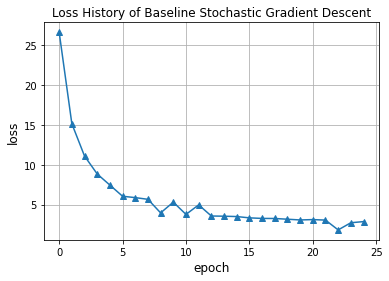

In [ ]:
plt.plot(loss_history_2, "-^")
#plt.yscale("log")
plt.grid(True)
plt.title("Loss History of Baseline Stochastic Gradient Descent")
plt.ylabel("loss", fontsize = 12)
plt.xlabel("epoch", fontsize = 12)

In [ ]:
compute_error_rate(beta_2, X_train, y_train)

DeviceArray(0.90553333, dtype=float64)

In [ ]:
compute_error_rate(beta_2, X_test, y_test)

DeviceArray(0.8942, dtype=float64)

In [ ]:
AUC(beta_2, X_test, y_test)

0.884590157096196

## 1.3 Stochastic Gradient Descent (with Momentum)

In [ ]:
def SGDM(beta, X_train, y_train, n_epoch, minibatch_size, learning_rate, gamma):
    start_time = time.time()
    N = len(X_train)
    img_indices = onp.arange(N)

    beta_previous = onp.copy(beta)
    loss_history = []
    loss_history_end_epoch = []
    for epoch in range(n_epoch):
        n_minibatch = N // minibatch_size + 1
        onp.random.shuffle(img_indices)

        all_loss_within_epoch = []
        for k in range(n_minibatch):
            batch_indices = onp.arange(k*minibatch_size, (k+1)*minibatch_size) % N
            batch_indices = img_indices[batch_indices]
            X_minibatch = X_train[batch_indices]
            y_minibatch = y_train[batch_indices]

            val, grad = loss_value_and_grad(beta, X_minibatch, y_minibatch)
            
            temp = beta
            beta = temp - learning_rate * grad + gamma * (temp - beta_previous)
            beta_previous = temp

            loss_history.append(val)
            all_loss_within_epoch.append(val)
        loss_history_end_epoch.append(onp.mean(all_loss_within_epoch))
        err_train = 100*compute_error_rate(beta, X_train, y_train)
        err_val= 100*compute_error_rate(beta, X_test, y_test)        
        print(f"epoch:{epoch} \t Loss:{val:2.3f} \t error(train):{err_train:2.1f}% \t error(val):{err_val:2.1f}%")
    print("Took", time.time() - start_time, "s to run.")
    return loss_history_end_epoch, beta

In [ ]:
n_epoch = 25
minibatch_size = 50
beta = onp.copy(beta_init)
learning_rate = 0.000001
gamma = 0.9

In [ ]:
loss_history_3, beta_3 = SGDM(beta, X_train, y_train, n_epoch, minibatch_size, learning_rate, gamma)

epoch:0 	 Loss:1.695 	 error(train):86.8% 	 error(val):85.4%
epoch:1 	 Loss:1.125 	 error(train):89.7% 	 error(val):87.5%
epoch:2 	 Loss:0.878 	 error(train):91.3% 	 error(val):88.6%
epoch:3 	 Loss:0.728 	 error(train):92.1% 	 error(val):88.9%
epoch:4 	 Loss:0.602 	 error(train):92.3% 	 error(val):89.4%
epoch:5 	 Loss:0.580 	 error(train):91.7% 	 error(val):89.2%
epoch:6 	 Loss:0.443 	 error(train):94.2% 	 error(val):89.8%
epoch:7 	 Loss:0.381 	 error(train):94.3% 	 error(val):89.9%
epoch:8 	 Loss:0.347 	 error(train):95.1% 	 error(val):90.2%
epoch:9 	 Loss:0.402 	 error(train):92.9% 	 error(val):89.1%
epoch:10 	 Loss:0.655 	 error(train):90.4% 	 error(val):87.6%
epoch:11 	 Loss:0.377 	 error(train):95.3% 	 error(val):90.1%
epoch:12 	 Loss:0.220 	 error(train):96.2% 	 error(val):90.3%
epoch:13 	 Loss:0.978 	 error(train):88.4% 	 error(val):86.9%
epoch:14 	 Loss:0.160 	 error(train):97.0% 	 error(val):90.5%
epoch:15 	 Loss:0.143 	 error(train):97.2% 	 error(val):90.5%
epoch:16 	 Loss:0.

Text(0.5, 0, 'epoch')

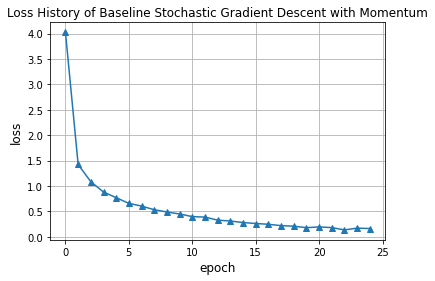

In [ ]:
plt.plot(loss_history_3, "-^")
#plt.yscale("log")
plt.grid(True)
plt.title("Loss History of Baseline Stochastic Gradient Descent with Momentum")
plt.ylabel("loss", fontsize = 12)
plt.xlabel("epoch", fontsize = 12)

In [ ]:
compute_error_rate(beta_3, X_train, y_train)

DeviceArray(0.95526667, dtype=float64)

In [ ]:
compute_error_rate(beta_3, X_test, y_test)

DeviceArray(0.9032, dtype=float64)

In [ ]:
AUC(beta_3, X_test, y_test)

0.8947168584899262

# 2. Model Training and Testing
> #### 2.1 Different sizes of training set
> #### 2.2 Different resolution


## 2.1 Different size of Training set

In [ ]:
def change_size(X, y, n):
    onp.random.seed(0)
    N = len(X)
    img_indices = onp.arange(N)
    onp.random.shuffle(img_indices)
    batch_indices = img_indices[:n]
    X_new = X[batch_indices]
    y_new = y[batch_indices]
    return X_new, y_new

In [ ]:
train_sizes = [1000, 3000, 5000, 7000, 9000, 11000, 13000, 15000]

In [ ]:
n_epoch = 10
learning_rate = 0.000001
gamma = 0.9
mini_batch_size = 50

In [ ]:
# training SGDM with different size of training dataset
all_history = []
all_beta = []

for t in train_sizes:
    start_time = time.time()
    X_new, y_new = change_size(X_train, y_train, t)
    beta = onp.copy(beta_init)
    l_hist, beta = SGDM(beta, X_new, y_new, n_epoch, minibatch_size, learning_rate, gamma)
    all_history.append(l_hist)
    all_beta.append(beta)
    del X_new, y_new, beta
    print(t, "done in", time.time() - start_time, "s.")

epoch:0 	 Loss:9.807 	 error(train):67.3% 	 error(val):67.8%
epoch:1 	 Loss:5.148 	 error(train):72.1% 	 error(val):73.9%
epoch:2 	 Loss:4.380 	 error(train):77.6% 	 error(val):77.4%
epoch:3 	 Loss:3.298 	 error(train):79.7% 	 error(val):80.4%
epoch:4 	 Loss:3.199 	 error(train):79.8% 	 error(val):80.5%
epoch:5 	 Loss:2.948 	 error(train):81.4% 	 error(val):80.9%
epoch:6 	 Loss:2.505 	 error(train):82.8% 	 error(val):83.2%
epoch:7 	 Loss:3.102 	 error(train):81.0% 	 error(val):80.8%
epoch:8 	 Loss:2.180 	 error(train):84.5% 	 error(val):84.5%
epoch:9 	 Loss:2.409 	 error(train):82.2% 	 error(val):82.7%
Took 72.99889779090881 s to run.
1000 done in 73.14244890213013 s.
epoch:0 	 Loss:4.188 	 error(train):78.9% 	 error(val):78.0%
epoch:1 	 Loss:3.068 	 error(train):82.2% 	 error(val):80.3%
epoch:2 	 Loss:2.142 	 error(train):85.8% 	 error(val):84.5%
epoch:3 	 Loss:1.866 	 error(train):86.9% 	 error(val):85.6%
epoch:4 	 Loss:1.783 	 error(train):86.9% 	 error(val):84.9%
epoch:5 	 Loss:1.5

Text(0.5, 0, 'epoch')

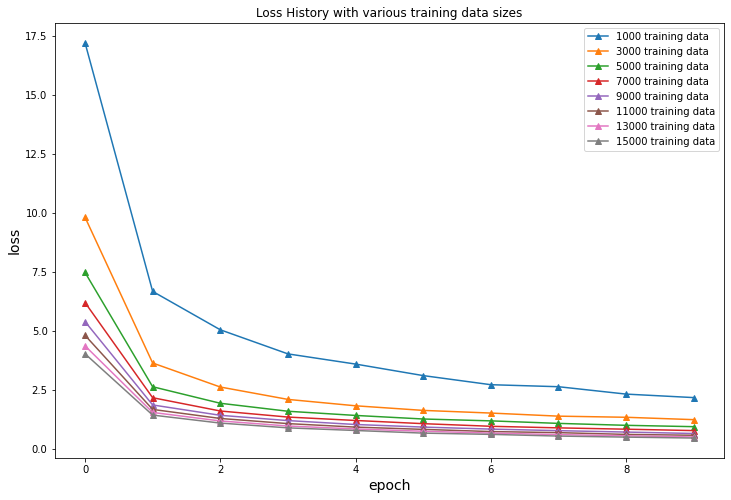

In [ ]:
plt.figure(figsize=(12,8))
a = 1000
for history in all_history:
    plt.plot(history, "-^", label=f"{a} training data")
    a += 2000
plt.legend()
plt.title("Loss History with various training data sizes")
plt.ylabel("loss", fontsize = 14)
plt.xlabel("epoch", fontsize = 14)

In [ ]:
a = 1000
for b in all_beta:
    print(a)
    print("test acc:", compute_error_rate(b, X_test, y_test))
    print("AUC:", AUC(b, X_test, y_test))
    a+=2000

1000
test acc: 0.8272
AUC: 0.8068975903070338
3000
test acc: 0.8534
AUC: 0.8624031666562384
5000
test acc: 0.8864000000000001
AUC: 0.8856391456413232
7000
test acc: 0.8932
AUC: 0.8915650482107744
9000
test acc: 0.8598
AUC: 0.8384157752111566
11000
test acc: 0.8502000000000001
AUC: 0.8651114046363076
13000
test acc: 0.901
AUC: 0.895125861381768
15000
test acc: 0.8914000000000001
AUC: 0.8967968529194069


## 2.2 Different resolution



In [ ]:
def change_resolution(res_x, res_y, arr):
    arr_2 = []
    for i in range(len(arr)):
        arr_2.append(resize(arr[i], (res_x, res_y)))
    return arr_2

In [ ]:
change_resolution(100, 100, df)

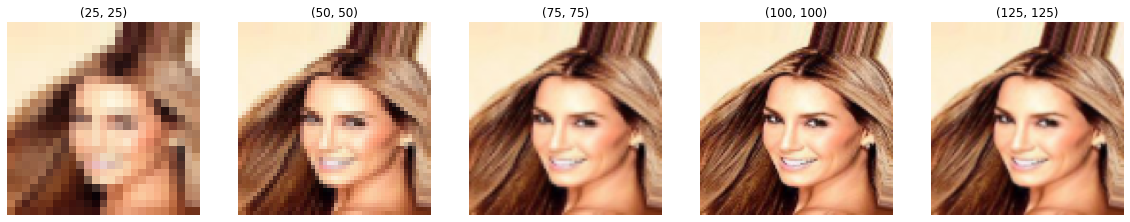

In [ ]:
plt.figure(figsize=(20,50))
for k in range(5):
    s = k * 25 + 25
    temp = resize(df[0], (s,s))
    plt.subplot(5,5,k+1)
    plt.imshow(temp/255.)
    plt.title(f"({s}, {s})")
    plt.axis("off")

In [ ]:
n_epoch = 10
learning_rate = 0.000001
gamma = 0.9
mini_batch_size = 10

In [ ]:
all_history_2 = []
all_beta_2 = []
res = [125, 100, 75, 50, 25]
onp.random.seed(30)

for k in range(5):
    start_time = time.time()
    s = res[k]
    temp_df = []
    for k, file in enumerate(all_img[:total_img_num]):
        im = imageio.imread(os.path.join(path, file)).astype(float)
        im = resize(im, (s,s))

        temp_df.append(im)
    print(s, "done resize.")
    dim = s * s * 3
    X_train = onp.array(temp_df[:11000]).reshape(11000, dim)
    X_test = onp.array(temp_df[15000:]).reshape(5000, dim)
    del temp_df
    beta = onp.random.normal(0,scale=1/np.sqrt(X_train.shape[1]),size=(X_train.shape[1]))
    l_hist, beta = SGDM(beta, X_train, y_train, n_epoch, mini_batch_size, learning_rate, gamma)
    all_history_2.append(l_hist)
    all_beta_2.append(beta)
    del X_train, X_test, beta, l_hist
    print(s, "X", s, "done in", time.time() - start_time, "s.")

125 done resize.


epoch:0 	 Loss:0.564 	 error(train):94.7% 	 error(val):90.2%
epoch:1 	 Loss:0.243 	 error(train):96.6% 	 error(val):90.0%
epoch:2 	 Loss:0.114 	 error(train):98.3% 	 error(val):90.4%
epoch:3 	 Loss:0.044 	 error(train):99.4% 	 error(val):90.0%
epoch:4 	 Loss:0.020 	 error(train):99.9% 	 error(val):89.8%
epoch:5 	 Loss:0.011 	 error(train):99.9% 	 error(val):89.6%
epoch:6 	 Loss:0.006 	 error(train):100.0% 	 error(val):89.5%
epoch:7 	 Loss:0.004 	 error(train):100.0% 	 error(val):89.4%
epoch:8 	 Loss:0.003 	 error(train):100.0% 	 error(val):89.4%
epoch:9 	 Loss:0.002 	 error(train):100.0% 	 error(val):89.4%
Took 5174.079727888107 s to run.
125 X 125 done in 5277.282674074173 s.
100 done resize.
epoch:0 	 Loss:0.670 	 error(train):92.6% 	 error(val):88.0%
epoch:1 	 Loss:0.395 	 error(train):94.1% 	 error(val):88.8%
epoch:2 	 Loss:0.235 	 error(train):94.7% 	 error(val):88.9%
epoch:3 	 Loss:0.098 	 error(train):98.4% 	 error(val):88.9%
epoch:4 	 Loss:0.058 	 error(train):99.1% 	 error(val

Text(0.5, 0, 'epoch')

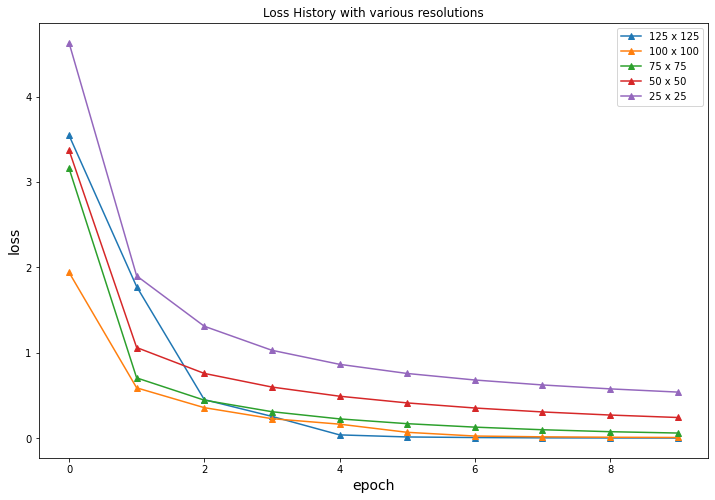

In [ ]:
plt.figure(figsize=(12,8))
b = 0
for history in all_history_2:
    a = res[b]
    plt.plot(history, "-^", label=f"{a} x {a}")
    b += 1
plt.legend()
plt.title("Loss History with various resolutions")
plt.ylabel("loss", fontsize = 14)
plt.xlabel("epoch", fontsize = 14)

In [ ]:
a = 0
for b in all_beta_2:
    s = res[a]
    print(s)
    temp_df = []
    for k, file in enumerate(all_img[:total_img_num]):
        im = imageio.imread(os.path.join(path, file)).astype(float)
        im = resize(im, (s,s))

        temp_df.append(im)
    X_test = onp.array(temp_df[15000:]).reshape(5000, s*s*3)
    del temp_df
    print("test acc:", compute_error_rate(b, X_test, y_test))
    print("AUC:", AUC(b, X_test, y_test))
    a+=1

125
test acc: 0.8944000000000001
AUC: 0.8912820881695606
100
test acc: 0.8888
AUC: 0.8850732255588953
75
test acc: 0.8882
AUC: 0.8840951823055873
50
test acc: 0.8904000000000001
AUC: 0.8872423121661814
25
test acc: 0.8628
AUC: 0.8570695423158283



# 3. Image Preprocessing
> #### 3.1 Exploratory analysis
> #### 3.2 Training model with Stochastic Gradient Descent with momentum (best model) on processed images

## 3.1 Exploratory analysis
### Functions created:
1. **black_and_white** : takes in image sub path and returns array of black and white image
2. **sharpened** : takes in image sub path and returns array of sharpened image
3. **blurred**: takes in image sub path and sigma and returns array of blurred image
4. **change_contrast** : takes in image sub path and a factor to determine the contrast and returns array of the modified image

In [ ]:
from PIL import Image, ImageEnhance
import cv2
import skimage.io
import skimage.filters

In [ ]:
def black_and_white(im):
    '''
    inputs: array of original image
    =========
    output: array of b&w image
    '''
    #load image
    # im = imageio.imread(os.path.join(path, im_path)).astype(float)
    #transform to black and white by averaging the 3 color channels
    im_output = np.mean(im, axis=2)
    return(im_output)

from functools import partial
#@partial(jax.jit, static_argnums=(1,))
def sharpened(im):
    '''
    inputs:  array of original image
    =========
    output: array of sharpened image
    '''
    # Defining the kernel of size 3x3
    # im = imageio.imread(os.path.join(path, im_path))
    kernel = onp.array([
        [0, -1, 0],
        [-1, 5, -1],
        [0, -1, 0]
    ])
    im_output = cv2.filter2D(im, -1, kernel)
    return(np.asarray(im_output))

def blurred(im, sigma):
    '''
    inputs:  im: array of original image
             sigma: to be used in x and y direction, 
                    (2*sigma*truncate) gives resulting kernel size
    =========
    output: array of blurred image
    '''
    # im = imageio.imread(os.path.join(path, im_path)).astype(float)
    blurred = skimage.filters.gaussian(
          im, sigma=(sigma, sigma), truncate=3.5, multichannel=True)
    return blurred

def change_contrast(im, factor):
    '''
    inputs:  im: a single image sub path,
            factor: number to control contrast, 1 gives original image,
                        < 1 decreases contrast and > 1 increases contrast
    =========
    output: array of new image
    '''
    # image brightness enhancer
    
    im = Image.fromarray(im.astype('uint8'))
    enhancer = ImageEnhance.Contrast(im)
    im_enhanced = enhancer.enhance(factor)
    im_output = np.asarray(im_enhanced)
    return(im_output)

### Original form 



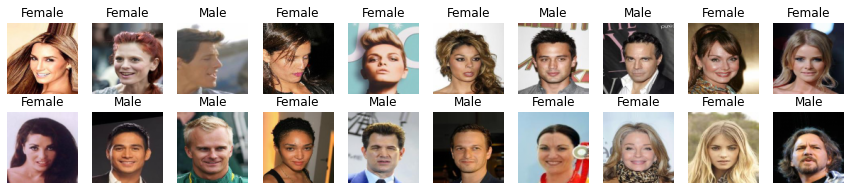

In [ ]:
# let us display the first 20 images in the original form and its labels
plt.figure(figsize=(15,3))
for k in range(20):
    #load image
    im = (df[k])
    #resize to 100x100 for display (you do not have to do this in the assignment)
    im = resize(im, (100,100) )
    #scale pixel intensity to [0,1] by divising by 255 and display
    plt.subplot(2,10,k+1)
    plt.imshow(im/255.)
    plt.axis("off")
    
    is_male = attribute["Male"][k]
    if is_male == 1:
        plt.title("Male")
    else:
        plt.title("Female")
    

### Black and White

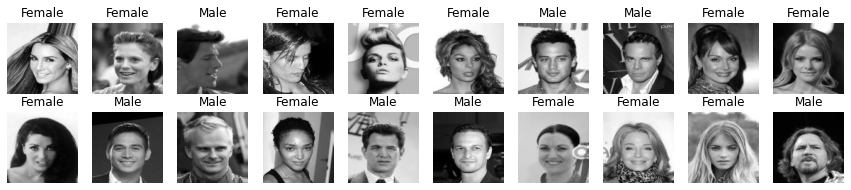

In [ ]:
#let us display the first 20 images in black and white
plt.figure(figsize=(15,3))
for k in range(20):
    #load black and white image
    im = black_and_white(df[k])
    #resize to 100x100
    im = resize(im, (100,100) )
    #scale pixel intensity to [0,1] by divising by 255 and display
    plt.subplot(2,10,k+1)
    plt.imshow(im/255., cmap="gray")
    plt.axis("off")

    is_male = attribute["Male"][k]
    if is_male == 1:
        plt.title("Male")
    else:
        plt.title("Female")

### Sharpen Image

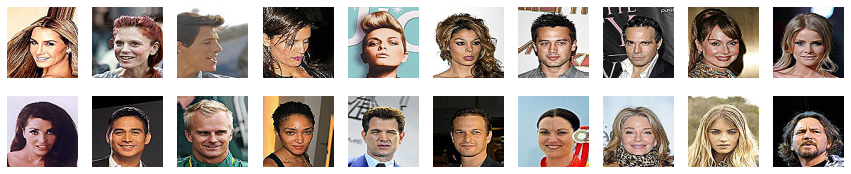

In [ ]:
# images with decreasing contrast
plt.figure(figsize = (15,3))
for k in range(20):
    # load sharpened image
    im = sharpened(df[k])
    # resize to 100x100
    im = resize(im, (100,100) )
    # plotting
    plt.subplot(2,10,k+1)
    plt.imshow(im/255.)
    plt.axis("off")

### Blur Images

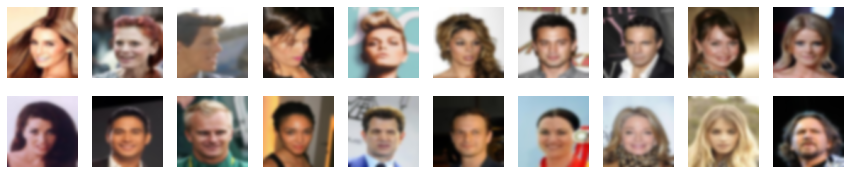

In [ ]:
#blurring of images with sigma = 2.0
plt.figure(figsize = (15,3))
for k in range(20):
    # change contrast of image
    im = blurred(df[k], 2.0)
    # resize to 100x100
    im = resize(im, (100,100) )
    # plotting
    plt.subplot(2,10,k+1)
    plt.imshow(im/255.)
    plt.axis("off")

Text(0.5, 1.0, 'Blurred')

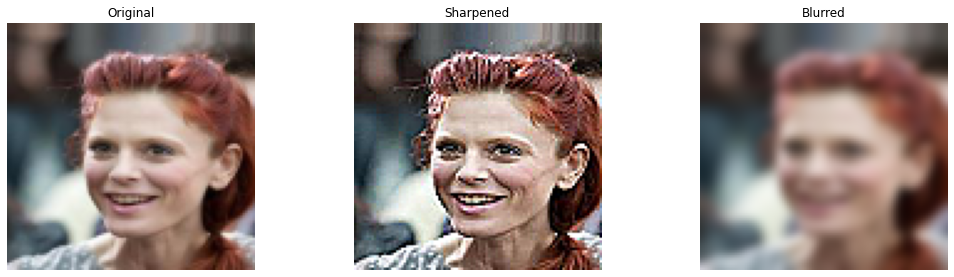

In [ ]:
#comparison between original, sharpened, blurred
im = df[1]
plt.figure(figsize = (30,10))
plt.subplot(2,5,1)
plt.imshow(im/255.)
plt.axis("off")
plt.title("Original")

plt.subplot(2,5,2)
plt.imshow(sharpened(im)/255.)
plt.axis("off")
plt.title("Sharpened")

plt.subplot(2,5,3)
plt.imshow(blurred(im, sigma = 2.0)/255.)
plt.axis("off")
plt.title("Blurred")

### Changing Contrast

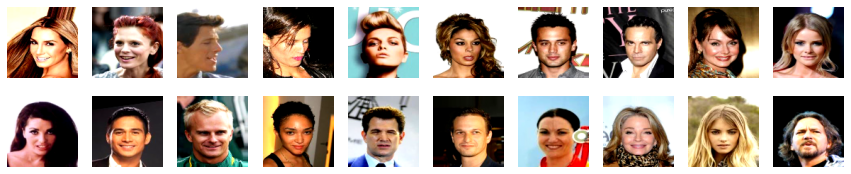

In [ ]:
# Higher contrast images
plt.figure(figsize = (15,3))
for k in range(20):
    # load image
    im = change_contrast(df[k], factor = 1.5)
    # resize to 100x100
    im = resize(im, (100,100) )
    # plotting
    plt.subplot(2,10,k+1)
    plt.imshow(im)
    plt.axis("off")

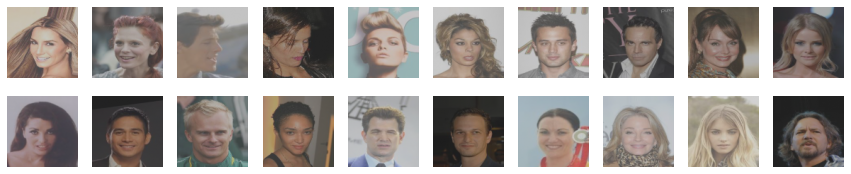

In [ ]:
# images with decreasing contrast
plt.figure(figsize = (15,3))
for k in range(20):
    # load image with changed contrast
    im = change_contrast(df[k], factor = 0.5)
    # resize to 100x100
    im = resize(im, (100,100) )
    # plotting
    plt.subplot(2,10,k+1)
    plt.imshow(im)
    plt.axis("off")


Text(0.5, 1.0, 'Lower Contrast')

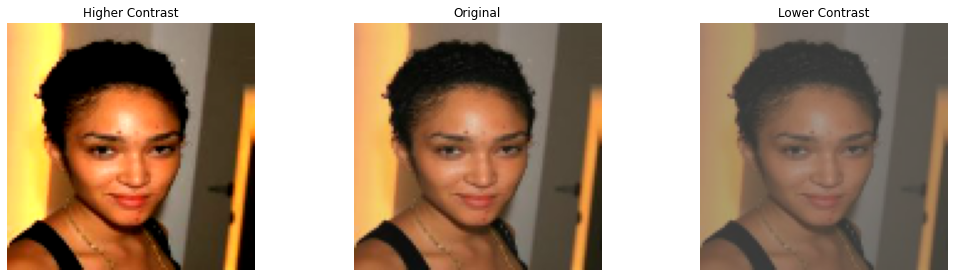

In [ ]:
#comparison between High contrast, original and low contrast
im = df[13]
plt.figure(figsize = (30,10))
plt.subplot(2,5,1)
plt.imshow(change_contrast(im, factor = 1.5))
plt.axis("off")
plt.title("Higher Contrast")

plt.subplot(2,5,2)
plt.imshow(im/255.)
plt.axis("off")
plt.title("Original")

plt.subplot(2,5,3)
plt.imshow(change_contrast(im, factor = 0.5))
plt.axis("off")
plt.title("Lower Contrast")

In [ ]:
# preprocess all images into black and white
# using vmap to preprocess the images
df1 = np.asarray(df)
bnw_vmapped = jax.jit(jax.vmap(black_and_white))
res_bw = bnw_vmapped(df1)

In [ ]:
# preprocess all images in the train dataset into blurred, sharpened, higher and lower contrast
# these functions cannot be run using vmap due to conversion errors
res_blur = [i for i in range(15000)]
res_sharp = [i for i in range(15000)]
res_highcontrast = [i for i in range(15000)]
res_lowcontrast = [i for i in range(15000)]
for i in range(15000):
    res_blur[i] = blurred(df[i], 2)
    res_sharp[i] = sharpened(df[i])
    res_highcontrast[i] = change_contrast(df[i], 1.5)
    res_lowcontrast[i] = change_contrast(df[i], 0.5)
    
# sharpen + high contrast + coloured
res_sharp_HC = [i for i in range(15000)]
for i in range(15000):
    res_sharp_HC[i] = sharpened(onp.asarray(res_highcontrast[i]))
    
# sharpen + high contrast + bnw
res_sharp_HC_bnw = [i for i in range(15000)]
for i in range(15000):
    res_sharp_HC_bnw[i] = black_and_white(res_sharp_HC[i])
    

## 3.2 Training model with Stochastic Gradient Descent with momentum (best model) on processed images

In [ ]:
def SGD_momentum(X_train, X_test, y_train, y_test, beta_init):
    
    start_time = time.time()
    n_epoch = 10
    minibatch_size = 50 #size of the minibatchs
    N = len(X_train)
    img_indices = onp.arange(N)

    loss_history3 = []
    loss_history_end_epoch3 = []
    beta = onp.copy(beta_init)
    beta_previous = onp.copy(beta_init)
    learning_rate = 0.000001
    gamma = 0.9

    for epoch in range(n_epoch):
        # go through all the minibatches, sequetially
        n_minibatch = N // minibatch_size + 1
        # randomize the batches
        onp.random.shuffle(img_indices) # need to keep the batches randomised

        all_loss_within_epoch = []
        for k in range(n_minibatch):
            # create the minibatch of examples
            batch_indices = onp.arange(k*minibatch_size, (k+1)*minibatch_size) % N # to ensure that we stay in the range of N
            batch_indices = img_indices[batch_indices]
            X_minibatch = X_train[batch_indices]
            y_minibatch = y_train[batch_indices]

            # compute the stochastic gradient
            val, grad = loss_value_and_grad(beta, X_minibatch, y_minibatch)

            # do one step of SGD

            temp = beta
            beta = temp - learning_rate * grad + gamma * (temp - beta_previous)
            beta_previous = temp

            # book-keeping
            loss_history3.append(val)
            all_loss_within_epoch.append(val)
        loss_history_end_epoch3.append(onp.mean(all_loss_within_epoch))
        err_train = 100*compute_error_rate(beta, X_train, y_train)
        err_val= 100*compute_error_rate(beta, X_test, y_test)        
        print(f"iter:{epoch} \t Loss:{val:2.3f} \t error(train):{err_train:2.1f}% \t error(val):{err_val:2.1f}%")
    print("Took", time.time() - start_time, "s to run")
    return (loss_history3, loss_history_end_epoch3, beta)

### SGD with momentum on original images

In [ ]:
onp.random.seed(30)
beta_init_SGD = onp.random.normal(0,scale=1/np.sqrt(100*100*3),size=(100*100*3))

In [ ]:
#minibatch_size = 50
X_train = onp.array(df[:15000]).reshape(15000, 100*100*3)
X_test = onp.array(df[15000:]).reshape(5000, 100*100*3)
y_train = onp.array(attribute.loc[:14999, 'Male'])
y_test = onp.array(attribute.loc[15000:, 'Male'])

# parameter of the logistic regression, generate it at random
onp.random.seed(30)
beta_init_SGD = onp.random.normal(0,scale=1/np.sqrt(100*100*3),size=(100*100*3))
beta_init = beta_init_SGD.copy()

# fitting and testing model
baseline_SGDM_loss_history = SGD_momentum(X_train, X_test, y_train, y_test, beta_init)

iter:0 	 Loss:1.695 	 error(train):86.8% 	 error(val):85.4%
iter:1 	 Loss:1.125 	 error(train):89.7% 	 error(val):87.5%
iter:2 	 Loss:0.878 	 error(train):91.3% 	 error(val):88.6%
iter:3 	 Loss:0.731 	 error(train):92.1% 	 error(val):88.9%
iter:4 	 Loss:0.655 	 error(train):91.9% 	 error(val):89.4%
iter:5 	 Loss:0.513 	 error(train):93.3% 	 error(val):89.6%
iter:6 	 Loss:1.376 	 error(train):87.3% 	 error(val):85.5%
iter:7 	 Loss:0.597 	 error(train):91.1% 	 error(val):88.0%
iter:8 	 Loss:0.345 	 error(train):94.3% 	 error(val):89.9%
iter:9 	 Loss:0.456 	 error(train):91.4% 	 error(val):88.9%
Took 1304.8920452594757 s to run


Text(0.5, 1.0, 'Loss history of SGD Baseline model')

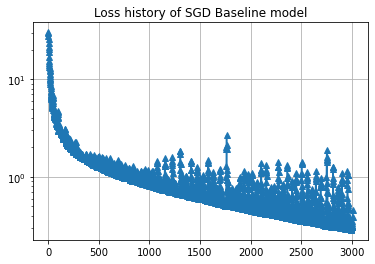

In [ ]:
plt.plot(baseline_SGDM_loss_history[0], "-^")
plt.yscale("log")
plt.grid(True)
plt.title('Loss history of SGD Baseline model')

In [ ]:
AUC(baseline_SGDM_loss_history[2], X_test, y_test)

0.8755902048857329

### SGD with momentum on Black and White images

In [ ]:
X_train = onp.array(res_bw[:15000]).reshape(15000, 100*100)
X_test = onp.array(res_bw[15000:]).reshape(5000, 100*100)
y_train = onp.array(attribute.loc[:14999, 'Male'])
y_test = onp.array(attribute.loc[15000:, 'Male'])

# parameter of the logistic regression, generate it at random
onp.random.seed(0)
beta_init = onp.random.normal(0,scale=1/np.sqrt(100*100),size=(100*100))

# fitting and testing model
bnw_SGDM_loss_history = SGD_momentum(X_train, X_test, y_train, y_test, beta_init)

iter:0 	 Loss:3.159 	 error(train):76.7% 	 error(val):77.0%
iter:1 	 Loss:2.169 	 error(train):81.7% 	 error(val):81.6%
iter:2 	 Loss:1.765 	 error(train):83.9% 	 error(val):83.3%
iter:3 	 Loss:1.520 	 error(train):85.4% 	 error(val):83.8%
iter:4 	 Loss:1.354 	 error(train):86.4% 	 error(val):84.5%
iter:5 	 Loss:1.227 	 error(train):87.1% 	 error(val):85.2%
iter:6 	 Loss:1.125 	 error(train):87.5% 	 error(val):85.5%
iter:7 	 Loss:1.040 	 error(train):88.1% 	 error(val):85.7%
iter:8 	 Loss:0.969 	 error(train):88.4% 	 error(val):85.9%
iter:9 	 Loss:0.907 	 error(train):88.7% 	 error(val):86.1%
Took 391.77038621902466 s to run


Text(0.5, 1.0, 'Loss history of SGD model with B&W images')

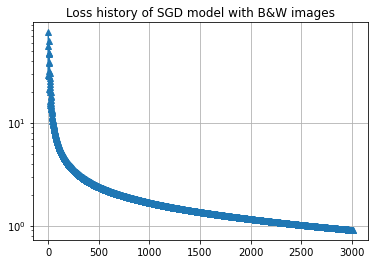

In [ ]:
plt.plot(bnw_SGDM_loss_history[0], "-^")
plt.yscale("log")
plt.grid(True)
plt.title('Loss history of SGD model with B&W images')

In [ ]:
X_test_bnw = onp.array(res_bw[15000:]).reshape(5000, 100*100)

In [ ]:
AUC(bnw_SGDM_loss_history[2], X_test, y_test)

0.8560703961227084

### SGD with momentum on blurred images

In [ ]:
X_train = onp.array(res_blur[:15000]).reshape(15000, 100*100*3)
X_test = onp.array(df[15000:]).reshape(5000, 100*100*3)
y_train = onp.array(attribute.loc[:14999, 'Male'])
y_test = onp.array(attribute.loc[15000:, 'Male'])

# parameter of the logistic regression, generate it at random
beta_init = beta_init_SGD.copy()

# fitting and testing model
blur_SGDM_loss_history = SGD_momentum(X_train, X_test, y_train, y_test, beta_init)

iter:0 	 Loss:1.695 	 error(train):83.0% 	 error(val):85.4%
iter:1 	 Loss:1.125 	 error(train):85.9% 	 error(val):87.5%
iter:2 	 Loss:0.878 	 error(train):87.7% 	 error(val):88.6%
iter:3 	 Loss:0.731 	 error(train):86.5% 	 error(val):88.9%
iter:4 	 Loss:0.655 	 error(train):91.0% 	 error(val):89.4%
iter:5 	 Loss:0.513 	 error(train):87.5% 	 error(val):89.6%
iter:6 	 Loss:1.376 	 error(train):72.7% 	 error(val):85.5%
iter:7 	 Loss:0.597 	 error(train):80.8% 	 error(val):88.0%
iter:8 	 Loss:0.345 	 error(train):91.5% 	 error(val):89.9%
iter:9 	 Loss:0.456 	 error(train):90.0% 	 error(val):88.9%
Took 1293.1322479248047 s to run


Text(0.5, 1.0, 'Loss history of SGD model with blurred images')

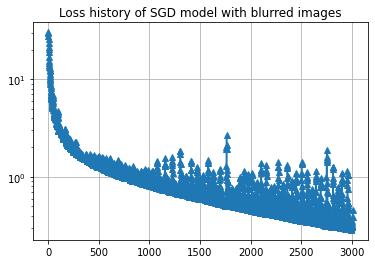

In [ ]:
plt.plot(blur_SGDM_loss_history[0], "-^")
plt.yscale("log")
plt.grid(True)
plt.title('Loss history of SGD model with blurred images')

In [ ]:
AUC(blur_SGDM_loss_history[2], X_test, y_test)

0.8755902048857329

### SGD with momentum on Sharpened images

In [ ]:
X_train = onp.array(res_sharp[:15000]).reshape(15000, 100*100*3)
X_test = onp.array(df[15000:]).reshape(5000, 100*100*3)
y_train = onp.array(attribute.loc[:14999, 'Male'])
y_test = onp.array(attribute.loc[15000:, 'Male'])

beta_init = beta_init_SGD.copy()

# fitting and testing model
sharp_SGDM_loss_history = SGD_momentum(X_train, X_test, y_train, y_test, beta_init)

iter:0 	 Loss:1.695 	 error(train):77.5% 	 error(val):85.4%
iter:1 	 Loss:1.125 	 error(train):80.0% 	 error(val):87.5%
iter:2 	 Loss:0.878 	 error(train):81.4% 	 error(val):88.6%
iter:3 	 Loss:0.731 	 error(train):82.1% 	 error(val):88.9%
iter:4 	 Loss:0.655 	 error(train):82.9% 	 error(val):89.4%
iter:5 	 Loss:0.513 	 error(train):83.2% 	 error(val):89.6%
iter:6 	 Loss:1.376 	 error(train):81.6% 	 error(val):85.5%
iter:7 	 Loss:0.597 	 error(train):82.9% 	 error(val):88.0%
iter:8 	 Loss:0.345 	 error(train):84.7% 	 error(val):89.9%
iter:9 	 Loss:0.456 	 error(train):84.9% 	 error(val):88.9%
Took 1042.9464418888092 s to run


Text(0.5, 1.0, 'Loss history of SGD model with sharpened images')

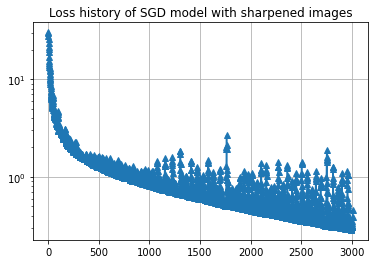

In [ ]:
plt.plot(sharp_SGDM_loss_history[0], "-^")
plt.yscale("log")
plt.grid(True)
plt.title('Loss history of SGD model with sharpened images')

In [ ]:
AUC(sharp_SGDM_loss_history[2], X_test, y_test)

0.8755902048857329

## SGD with momentum on Higher contrast images

In [ ]:
X_train = onp.array(res_highcontrast[:15000]).reshape(15000, 100*100*3)
X_test = onp.array(df[15000:]).reshape(5000, 100*100*3)
y_train = onp.array(attribute.loc[:14999, 'Male'])
y_test = onp.array(attribute.loc[15000:, 'Male'])

# parameter of the logistic regression, generate it at random
beta_init = beta_init_SGD.copy()

# fitting and testing model
HC_SGDM_loss_history = SGD_momentum(X_train, X_test, y_train, y_test, beta_init)

iter:0 	 Loss:1.927 	 error(train):88.2% 	 error(val):85.6%
iter:1 	 Loss:1.289 	 error(train):90.4% 	 error(val):87.7%
iter:2 	 Loss:0.978 	 error(train):91.4% 	 error(val):87.4%
iter:3 	 Loss:0.741 	 error(train):92.5% 	 error(val):88.7%
iter:4 	 Loss:0.599 	 error(train):93.7% 	 error(val):88.4%
iter:5 	 Loss:0.463 	 error(train):94.5% 	 error(val):88.5%
iter:6 	 Loss:0.454 	 error(train):94.0% 	 error(val):89.4%
iter:7 	 Loss:0.315 	 error(train):95.7% 	 error(val):89.0%
iter:8 	 Loss:0.276 	 error(train):96.2% 	 error(val):88.9%
iter:9 	 Loss:0.243 	 error(train):96.2% 	 error(val):88.3%
Took 1070.093819141388 s to run


Text(0.5, 1.0, 'Loss history of SGD model with Higher Contrast images')

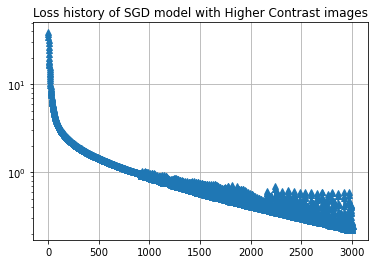

In [ ]:
plt.plot(HC_SGDM_loss_history[0], "-^")
plt.yscale("log")
plt.grid(True)
plt.title('Loss history of SGD model with Higher Contrast images')

In [ ]:
AUC(HC_SGDM_loss_history[2], X_test, y_test)

0.8866855886956561

### SGD with momentum on Lower contrast images

In [ ]:
X_train = onp.array(res_lowcontrast[:15000]).reshape(15000, 100*100*3)
X_test = onp.array(df[15000:]).reshape(5000, 100*100*3)
y_train = onp.array(attribute.loc[:14999, 'Male'])
y_test = onp.array(attribute.loc[15000:, 'Male'])

# parameter of the logistic regression, generate it at random
beta_init = beta_init_SGD.copy()

# fitting and testing model
LC_SGDM_loss_history = SGD_momentum(X_train, X_test, y_train, y_test, beta_init)

iter:0 	 Loss:1.927 	 error(train):80.6% 	 error(val):85.6%
iter:1 	 Loss:1.289 	 error(train):86.4% 	 error(val):87.7%
iter:2 	 Loss:0.978 	 error(train):80.1% 	 error(val):87.4%
iter:3 	 Loss:0.741 	 error(train):90.1% 	 error(val):88.7%
iter:4 	 Loss:0.599 	 error(train):85.3% 	 error(val):88.4%
iter:5 	 Loss:0.463 	 error(train):88.4% 	 error(val):88.5%
iter:6 	 Loss:0.454 	 error(train):93.5% 	 error(val):89.4%
iter:7 	 Loss:0.315 	 error(train):91.4% 	 error(val):89.0%
iter:8 	 Loss:0.276 	 error(train):89.9% 	 error(val):88.9%
iter:9 	 Loss:0.243 	 error(train):87.4% 	 error(val):88.3%
Took 1063.4786639213562 s to run


Text(0.5, 1.0, 'Loss history of SGD model with Lower Contrast images')

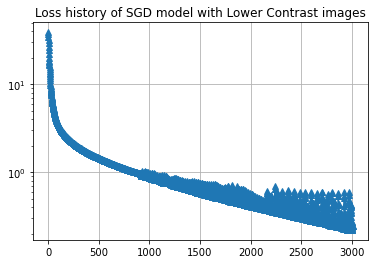

In [ ]:
plt.plot(LC_SGDM_loss_history[0], "-^")
plt.yscale("log")
plt.grid(True)
plt.title('Loss history of SGD model with Lower Contrast images')

In [ ]:
AUC(LC_SGDM_loss_history[2], X_test, y_test)

0.8866855886956561

### SGD with momentum on coloured + sharpened + high contrast images

In [ ]:
X_train = onp.array(res_sharp_HC[:15000]).reshape(15000, 100*100*3)
X_test = onp.array(df[15000:]).reshape(5000, 100*100*3)
y_train = onp.array(attribute.loc[:14999, 'Male'])
y_test = onp.array(attribute.loc[15000:, 'Male'])

# parameter of the logistic regression, generate it at random
beta_init = beta_init_SGD.copy()

# fitting and testing model
sharpHC_SGDM_loss_history = SGD_momentum(X_train, X_test, y_train, y_test, beta_init)

iter:0 	 Loss:1.927 	 error(train):80.7% 	 error(val):85.6%
iter:1 	 Loss:1.289 	 error(train):82.4% 	 error(val):87.7%
iter:2 	 Loss:0.978 	 error(train):83.0% 	 error(val):87.4%
iter:3 	 Loss:0.741 	 error(train):83.8% 	 error(val):88.7%
iter:4 	 Loss:0.599 	 error(train):84.0% 	 error(val):88.4%
iter:5 	 Loss:0.463 	 error(train):84.5% 	 error(val):88.5%
iter:6 	 Loss:0.454 	 error(train):85.3% 	 error(val):89.4%
iter:7 	 Loss:0.315 	 error(train):85.2% 	 error(val):89.0%
iter:8 	 Loss:0.276 	 error(train):85.5% 	 error(val):88.9%
iter:9 	 Loss:0.243 	 error(train):85.3% 	 error(val):88.3%
Took 1617.5573930740356 s to run


Text(0.5, 1.0, 'Loss history of SGD model with Sharpened, High Contrast images')

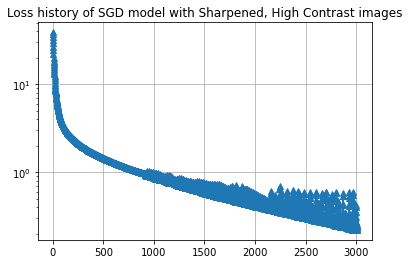

In [ ]:
plt.plot(sharpHC_SGDM_loss_history[0], "-^")
plt.yscale("log")
plt.grid(True)
plt.title('Loss history of SGD model with Sharpened, High Contrast images')

In [ ]:
AUC(sharpHC_SGDM_loss_history[2], X_test, y_test)

0.8866855886956561

### SGD with momentum on Black&White + sharpened + high contrast images


In [ ]:
X_train = onp.array(res_sharp_HC_bnw[:15000]).reshape(15000, 100*100)
X_test = onp.array(res_bw[15000:]).reshape(5000, 100*100)
y_train = onp.array(attribute.loc[:14999, 'Male'])
y_test = onp.array(attribute.loc[15000:, 'Male'])

# parameter of the logistic regression, generate it at random
onp.random.seed(0)
beta_init = onp.random.normal(0,scale=1/np.sqrt(100*100),size=(100*100))

# fitting and testing model
bnw_sharp_HC_SGDM_loss_history = SGD_momentum(X_train, X_test, y_train, y_test, beta_init)

iter:0 	 Loss:3.159 	 error(train):71.3% 	 error(val):77.0%
iter:1 	 Loss:2.169 	 error(train):75.3% 	 error(val):81.6%
iter:2 	 Loss:1.765 	 error(train):77.3% 	 error(val):83.3%
iter:3 	 Loss:1.520 	 error(train):78.4% 	 error(val):83.8%
iter:4 	 Loss:1.354 	 error(train):79.1% 	 error(val):84.5%
iter:5 	 Loss:1.227 	 error(train):79.6% 	 error(val):85.2%
iter:6 	 Loss:1.125 	 error(train):80.0% 	 error(val):85.5%
iter:7 	 Loss:1.040 	 error(train):80.4% 	 error(val):85.7%
iter:8 	 Loss:0.969 	 error(train):80.7% 	 error(val):85.9%
iter:9 	 Loss:0.907 	 error(train):80.9% 	 error(val):86.1%
Took 344.0757851600647 s to run


Text(0.5, 1.0, 'Loss history of SGD model with B&W, Sharpened, High Contrast images')

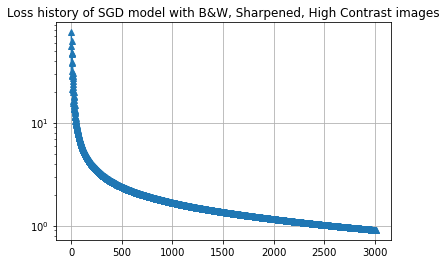

In [ ]:
plt.plot(bnw_sharp_HC_SGDM_loss_history[0], "-^")
plt.yscale("log")
plt.grid(True)
plt.title('Loss history of SGD model with B&W, Sharpened, High Contrast images')

In [ ]:
AUC(bnw_sharp_HC_SGDM_loss_history[2], X_test, y_test)

0.8560703961227084